# Imports

In [4]:
# 2. Font Recognition Pipeline.ipynb
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from pipeline_helpers import preprocess_image, segment_characters
from config.settings import DATABASE, DEBUG

/Users/yc/anaconda3/envs/Fontsfinder/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yc/anaconda3/envs/Fontsfinder/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


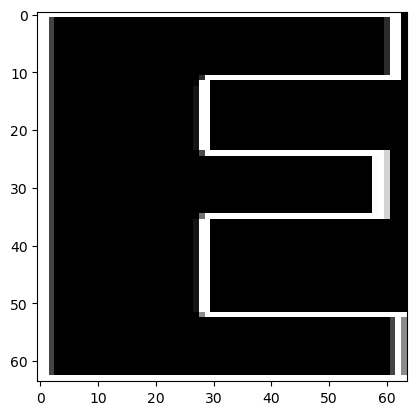

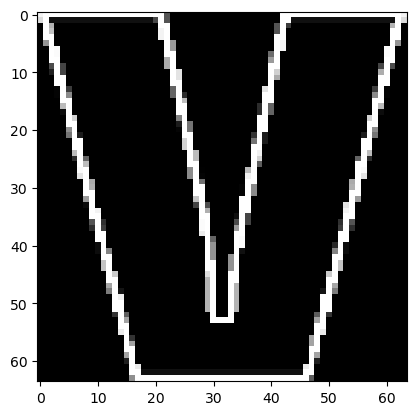

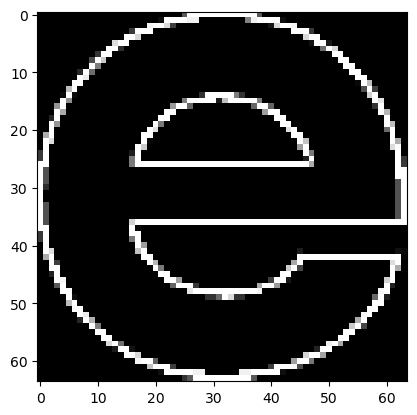

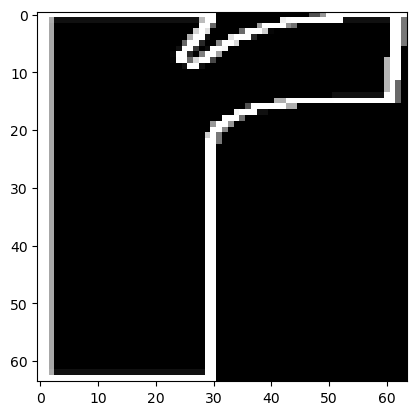

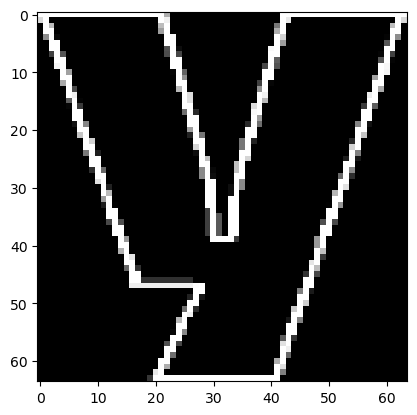

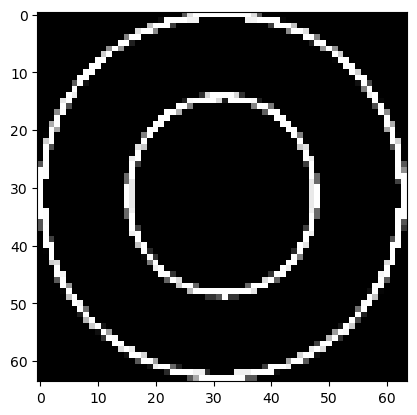

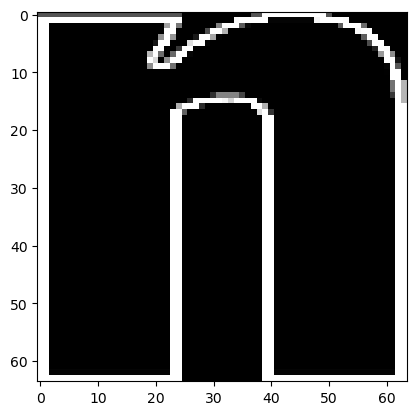

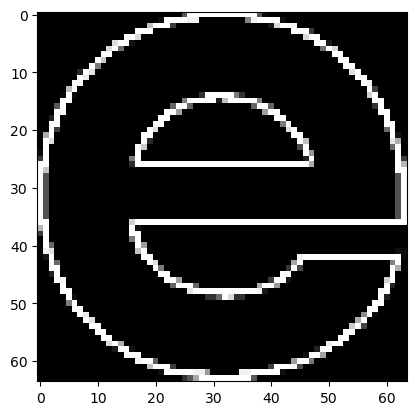

Detected text: Everyone


In [5]:
# Example usage
image_path = "../example_images/test.png"
processed = preprocess_image(image_path)
chars = segment_characters(processed)

# Verify characters with user input
detected_text = []
for i, char_img in enumerate(chars):
    plt.imshow(char_img, cmap='gray')
    plt.show()
    char = input(f"Enter character {i+1}: ")
    detected_text.append(char)

text = "".join(detected_text)
print("Detected text:", text)

In [ ]:
from pipeline_helpers import match_characters

# Then in your main processing loop:
font_scores = match_characters(chars, detected_text)

# Aggregate scores per font (average similarity)
final_scores = []
for font_id, scores in font_scores.items():
    avg_score = np.mean(scores)
    final_scores.append((font_id, avg_score))

# Sort by highest similarity
final_scores.sort(key=lambda x: x[1], reverse=True)
print("final_scores", final_scores)

final_scores [(244, np.float32(0.47947362)), (1200, np.float32(0.46994576)), (1669, np.float32(0.4685735)), (1541, np.float32(0.46431094)), (928, np.float32(0.46281624)), (1897, np.float32(0.46062833)), (782, np.float32(0.45828733)), (924, np.float32(0.4574716)), (1570, np.float32(0.45290813)), (1569, np.float32(0.4509732)), (1355, np.float32(0.4502851)), (1278, np.float32(0.44975275)), (1119, np.float32(0.4466747)), (1320, np.float32(0.44566864)), (1665, np.float32(0.44561845)), (1272, np.float32(0.44550413)), (1744, np.float32(0.4452459)), (79, np.float32(0.44512278)), (1087, np.float32(0.4448055)), (1241, np.float32(0.44475913)), (261, np.float32(0.44469965)), (1381, np.float32(0.4446866)), (1181, np.float32(0.44332427)), (938, np.float32(0.44313997)), (1300, np.float32(0.44311994)), (1192, np.float32(0.44304866)), (1952, np.float32(0.4425172)), (489, np.float32(0.4424862)), (1896, np.float32(0.44225734)), (1856, np.float32(0.44191083)), (56, np.float32(0.4413995)), (460, np.float32

In [7]:
from db_helpers import get_fontinfo_from_id

for font_id, scores in final_scores[:3]:
    font_info = get_fontinfo_from_id(font_id)  # Get info for font with ID 1
    if font_info:
        print(f"Font Family: {font_info['family']}")
        print(f"Style: {font_info['style']}")
        print(f"Weight: {font_info['weight']}")
        print(f"File Path: {font_info['file_path']}")
    else:
        print("Font not found")

Font Family: Diplomata
Style: Regular
Weight: 400
File Path: ../db/google-fonts/diplomata/Diplomata-Regular.ttf
Font Family: Ruge Boogie
Style: Regular
Weight: 400
File Path: ../db/google-fonts/rugeboogie/RugeBoogie-Regular.ttf
Font Family: Monofett
Style: Regular
Weight: 400
File Path: ../db/google-fonts/monofett/Monofett-Regular.ttf
